## Adapted from Seurat pre-processing in the ScanPy documentation

https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

In [1]:
data_loc = '/Users/pk/Data/'

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import pickle
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = data_loc + 'Seurat.h5ad'  # the file that will store the analysis results

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.9 numpy==1.14.5 scipy==1.3.0 pandas==0.23.3 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [3]:
sc.settings.set_figure_params(dpi=80)

In [4]:
adata_old = sc.read_10x_mtx(data_loc + 
    'filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)                                # write a cache file for faster subsequent reading
print(adata_old.var_names[:10])
del adata_old

... reading from cache file cache/Users-pk-Data-filtered_gene_bc_matrices-hg19-matrix.h5ad
Index(['MIR1302-10', 'FAM138A', 'OR4F5', 'RP11-34P13.7', 'RP11-34P13.8',
       'AL627309.1', 'RP11-34P13.14', 'RP11-34P13.9', 'AP006222.2',
       'RP4-669L17.10'],
      dtype='object')


In [5]:
# Set up data loading

#Data files
sample_strings = ['Duo_M1', 'Duo_M2', 'Jej_M1', 'Jej_M2', 'Il_M1', 'Il_M2']
sample_id_strings = ['3', '4', '5', '6', '7', '8']
file_base = data_loc + 'GSE92332_RAW/GSM283657'
exp_string = '_Regional_'
data_file_end = '_matrix.mtx'
barcode_file_end = '_barcodes.tsv'
gene_file_end = '_genes.tsv'
cc_genes_file = '../Macosko_cell_cycle_genes.txt'

# First data set load & annotation
#Parse Filenames
sample = sample_strings.pop(0)
sample_id = sample_id_strings.pop(0)
data_file = file_base+sample_id+exp_string+sample+data_file_end
barcode_file = file_base+sample_id+exp_string+sample+barcode_file_end
gene_file = file_base+sample_id+exp_string+sample+gene_file_end

#Load data
adata = sc.read(data_file, cache=True)
adata = adata.transpose()
adata.X = adata.X.toarray()

barcodes = pd.read_csv(barcode_file, header=None, sep='\t')
genes = pd.read_csv(gene_file, header=None, sep='\t')

#Annotate data
barcodes.rename(columns={0:'barcode'}, inplace=True)
barcodes.set_index('barcode', inplace=True)
adata.obs = barcodes
adata.obs['sample'] = [sample]*adata.n_obs
adata.obs['region'] = [sample.split("_")[0]]*adata.n_obs
adata.obs['donor'] = [sample.split("_")[1]]*adata.n_obs

genes.rename(columns={0:'gene_id', 1:'gene_symbol'}, inplace=True)
genes.set_index('gene_symbol', inplace=True)
adata.var = genes

# Loop to load rest of data sets
for i in range(len(sample_strings)):
    #Parse Filenames
    sample = sample_strings[i]
    sample_id = sample_id_strings[i]
    data_file = file_base+sample_id+exp_string+sample+data_file_end
    barcode_file = file_base+sample_id+exp_string+sample+barcode_file_end
    gene_file = file_base+sample_id+exp_string+sample+gene_file_end
    
    #Load data
    adata_tmp = sc.read(data_file, cache=True)
    adata_tmp = adata_tmp.transpose()
    adata_tmp.X = adata_tmp.X.toarray()

    barcodes_tmp = pd.read_csv(barcode_file, header=None, sep='\t')
    genes_tmp = pd.read_csv(gene_file, header=None, sep='\t')
    
    #Annotate data
    barcodes_tmp.rename(columns={0:'barcode'}, inplace=True)
    barcodes_tmp.set_index('barcode', inplace=True)
    adata_tmp.obs = barcodes_tmp
    adata_tmp.obs['sample'] = [sample]*adata_tmp.n_obs
    adata_tmp.obs['region'] = [sample.split("_")[0]]*adata_tmp.n_obs
    adata_tmp.obs['donor'] = [sample.split("_")[1]]*adata_tmp.n_obs
    
    genes_tmp.rename(columns={0:'gene_id', 1:'gene_symbol'}, inplace=True)
    genes_tmp.set_index('gene_symbol', inplace=True)
    adata_tmp.var = genes_tmp
    adata_tmp.var_names_make_unique()

    # Concatenate to main adata object
    adata = adata.concatenate(adata_tmp, batch_key='sample_id')
    adata.obs.drop(columns=['sample_id'], inplace=True)
    adata.obs_names = [c.split("-")[0] for c in adata.obs_names]
    adata.obs_names_make_unique(join='_')

del adata_tmp

... reading from cache file cache/Users-pk-Data-GSE92332_RAW-GSM2836573_Regional_Duo_M1_matrix.h5ad
... reading from cache file cache/Users-pk-Data-GSE92332_RAW-GSM2836574_Regional_Duo_M2_matrix.h5ad


Making variable names unique for controlled concatenation.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


... reading from cache file cache/Users-pk-Data-GSE92332_RAW-GSM2836575_Regional_Jej_M1_matrix.h5ad


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


... reading from cache file cache/Users-pk-Data-GSE92332_RAW-GSM2836576_Regional_Jej_M2_matrix.h5ad


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


... reading from cache file cache/Users-pk-Data-GSE92332_RAW-GSM2836577_Regional_Il_M1_matrix.h5ad


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


... reading from cache file cache/Users-pk-Data-GSE92332_RAW-GSM2836578_Regional_Il_M2_matrix.h5ad


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [6]:
print(adata.var_names[:10])
#Assign variable names and gene id columns
adata.var_names = [g.split("_")[1] for g in adata.var_names]
adata.var['gene_id'] = [g.split("_")[1] for g in adata.var['gene_id']]
print(adata.var_names[:10])

Index(['mm10_Xkr4', 'mm10_Gm1992', 'mm10_Gm37381', 'mm10_Rp1', 'mm10_Rp1-1',
       'mm10_Sox17', 'mm10_Gm37323', 'mm10_Mrpl15', 'mm10_Lypla1',
       'mm10_Gm37988'],
      dtype='object')
Index(['Xkr4', 'Gm1992', 'Gm37381', 'Rp1', 'Rp1-1', 'Sox17', 'Gm37323',
       'Mrpl15', 'Lypla1', 'Gm37988'],
      dtype='object')


In [7]:
print(adata.shape)
print(adata)
# ComBat batch correction
sc.pp.combat(adata, key='sample')
print(adata)

... storing 'donor' as categorical
... storing 'region' as categorical
... storing 'sample' as categorical


(13353, 27998)
AnnData object with n_obs × n_vars = 13353 × 27998 
    obs: 'donor', 'region', 'sample'
    var: 'gene_id'
Standardizing Data across genes.

Found 6 batches

Found 0 numerical variables:
	

Found 10704 genes with zero variance.
Fitting L/S model and finding priors

Finding parametric adjustments



/usr/local/lib/python3.7/site-packages/scanpy/preprocessing/_combat.py:269: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "_it_sol" failed type inference due to: Cannot unify array(float64, 2d, C) and array(float64, 1d, C) for 'sum2', defined at /usr/local/lib/python3.7/site-packages/scanpy/preprocessing/_combat.py (311)

File "../../../../../usr/local/lib/python3.7/site-packages/scanpy/preprocessing/_combat.py", line 311:
def _it_sol(s_data, g_hat, d_hat, g_bar, t2, a, b, conv=0.0001) -> Tuple[float, float]:
    <source elided>
        g_new = (t2*n*g_hat + d_old*g_bar) / (t2*n + d_old)
        sum2 = s_data - g_new.reshape((g_new.shape[0], 1)) @ np.ones((1, s_data.shape[1]))
        ^

[1] During: typing of assignment at /usr/local/lib/python3.7/site-packages/scanpy/preprocessing/_combat.py (313)

File "../../../../../usr/local/lib/python3.7/site-packages/scanpy/preprocessing/_combat.py", line 313:
def _it_sol(s_data, g_hat, d_hat

Adjusting data

AnnData object with n_obs × n_vars = 13353 × 27998 
    obs: 'donor', 'region', 'sample'
    var: 'gene_id'


In [8]:
adata.var_names_make_unique()  # this is unnecessary if using 'gene_ids'

## Preprocessing

Show those genes that yield the highest fraction of counts in each single cells, across all cells.

normalizing by total count per cell
    finished (0:00:38): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


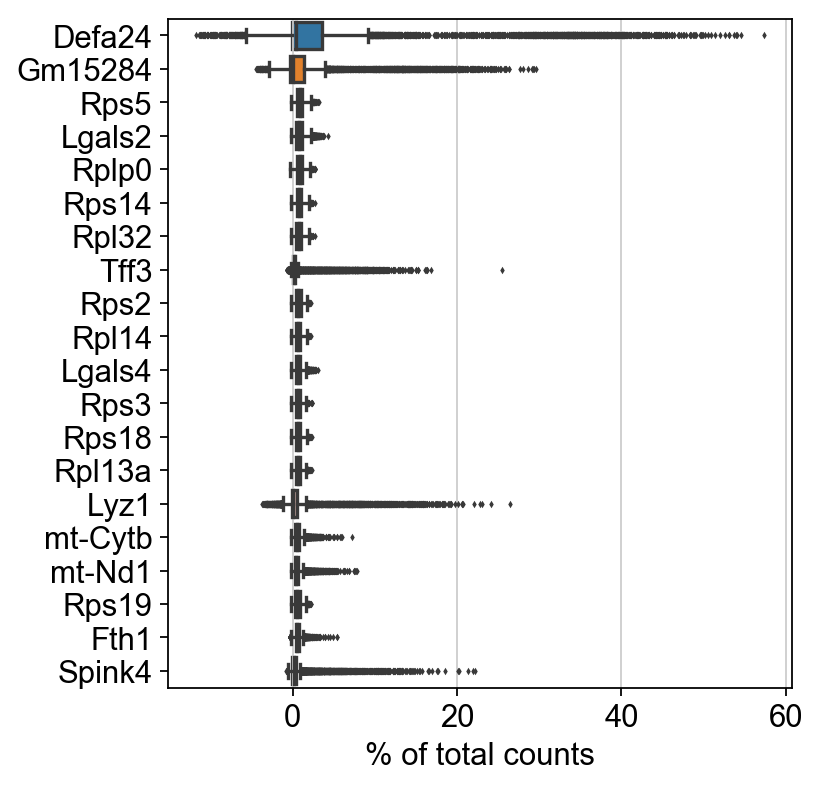

In [9]:
sc.pl.highest_expr_genes(adata, n_top=20)

Basic filtering.

In [10]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 10704 genes that are detectedin less than 3 cells


In [11]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)

normalizing by total count per cell
    finished (0:00:03): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


/usr/local/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:291: RuntimeWarning: invalid value encountered in log1p
  np.log1p(X, out=X)


In [12]:
adata_pp.X = np.nan_to_num(adata_pp.X)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)

# perform Louvain cluster, larger resolution increases number of cluster, decreases cluster size
sc.tl.louvain(adata_pp, key_added='louvain_r1')
sc.tl.louvain(adata_pp, resolution=0.5, key_added='louvain_r05', random_state=10)

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 15
    finished (0:00:14)
computing neighbors
    using 'X_pca' with n_pcs = 15


/usr/local/lib/python3.7/site-packages/umap/rp_tree.py:450: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "make_euclidean_tree" failed type inference due to: Cannot unify RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none) and RandomProjectionTreeNode(none, bool, array(float32, 1d, C), float64, RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none), RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none)) for '$14.16', defined at /usr/local/lib/python3.7/site-packages/umap/rp_tree.py (457)

File "../../../../../usr/local/lib/python3.7/site-packages/umap/rp_tree.py", line 457:
def make_euclidean_tree(data, indices, rng_state, leaf_size=30):
    <source elided>

        left_node = make_euclidean_tree(data, left_indices, rng_state, leaf_size)
        ^

[1] During: resolving callee type: recursive(type(CPUDispatcher(<function make_euclidean_tree at 0x11f1383b0>)))
[2] Du

    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:08)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 26 clusters and added
    'louvain_r1', the cluster labels (adata.obs, categorical) (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 18 clusters and added
    'louvain_r05', the cluster labels (adata.obs, categorical) (0:00:01)


In [13]:
# Save lists of Louvain cluster labels
with open(data_loc + 'louvain_r05_labels_Seurat.pickle', 'wb') as handle:
    pickle.dump(adata_pp.obs.louvain_r05.tolist()[:2000], handle)
    
with open(data_loc + 'louvain_r1_labels_Seurat.pickle', 'wb') as handle:
    pickle.dump(adata_pp.obs.louvain_r1.tolist()[:2000], handle)

In [14]:
mito_genes = adata.var_names.str.startswith('mt-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1)

In [15]:
adata.shape

(13353, 17294)

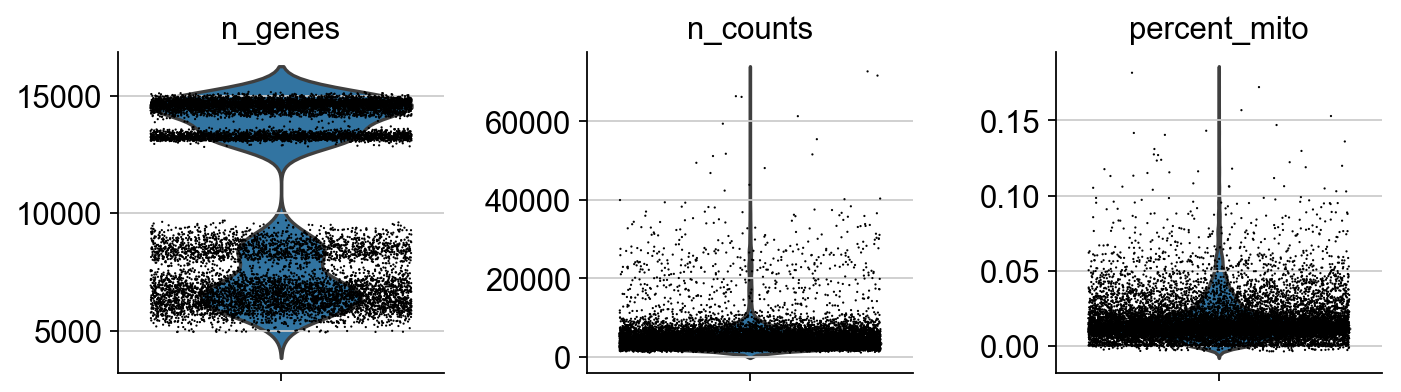

In [16]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

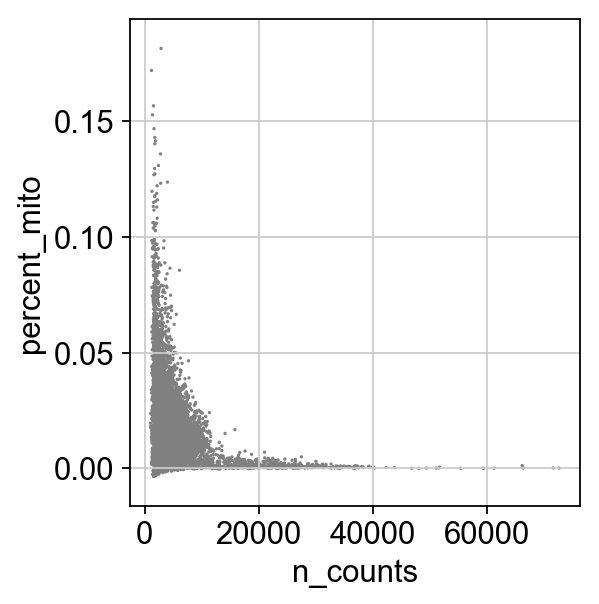

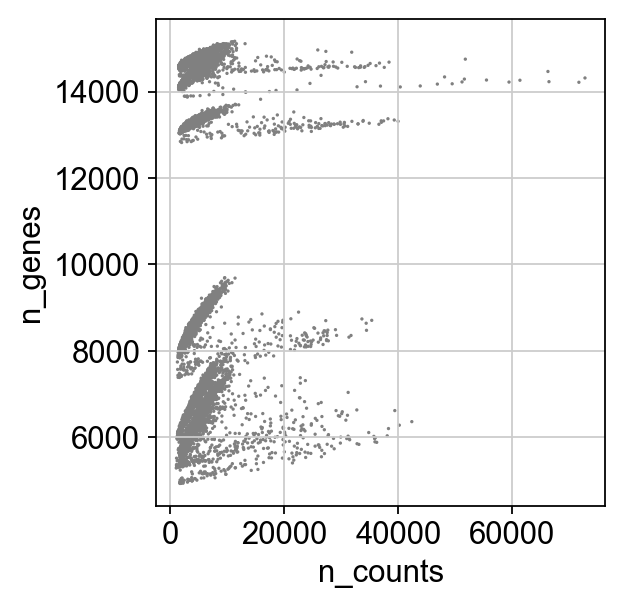

In [17]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [18]:
adata = adata[adata.obs['percent_mito'] < 0.1, :]

In [19]:
adata.shape

(13317, 17294)

Total-count normalize (library-size correct) the data matrix $\mathbf{X}$ to 10,000 reads per cell, so that counts become comparable among cells.

In [20]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

normalizing by total count per cell


Trying to set attribute `.obs` of view, making a copy.


    finished (0:00:04): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


Logarithmize the data.

In [21]:
sc.pp.log1p(adata)

/usr/local/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:291: RuntimeWarning: invalid value encountered in log1p
  np.log1p(X, out=X)


Set the `.raw` attribute of AnnData object to the logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object. While many people consider the normalized data matrix as the "relevant data" for visualization and differential testing, some would prefer to store the unnormalized data.

In [22]:
from sys import getsizeof
getsizeof(adata)/(1024**3)

0.8627391755580902

Identify highly-variable genes.

### Save pre-HVG data file

In [23]:
adata.write(data_loc + 'adata_Seurat_compressed.h5ad', compression='gzip')